/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Model training and prediction completed successfully!


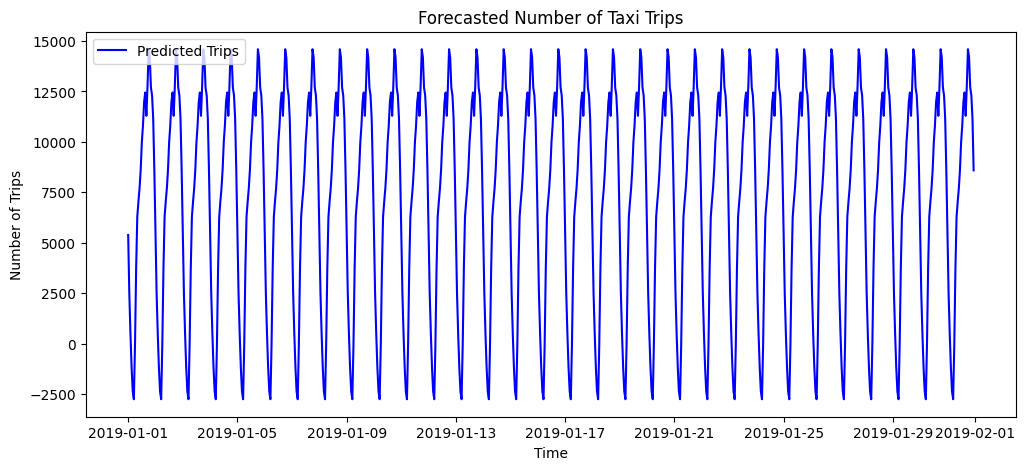

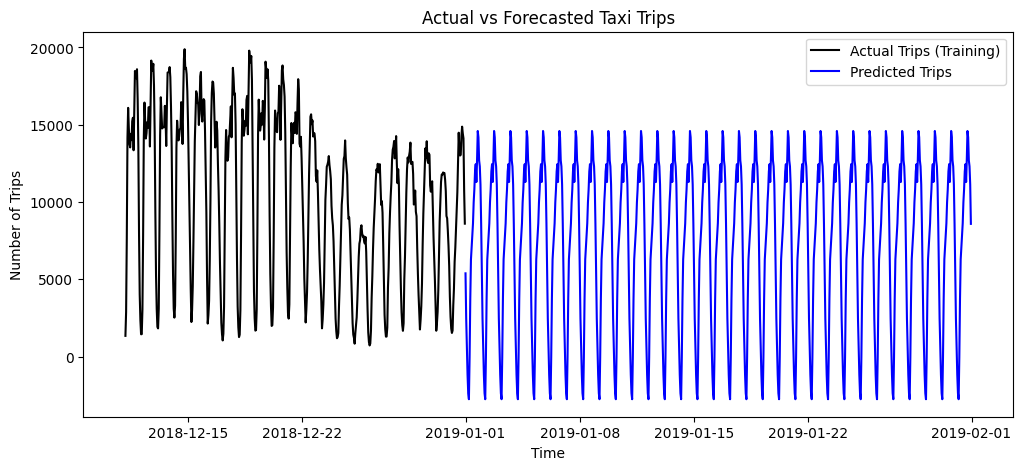

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.statespace.varmax import VARMAX
import pickle

# Load training data
train_url = "https://github.com/dustywhite7/econ8310-assignment1/raw/main/assignment_data_train.csv"
train_data = pd.read_csv(train_url)

# Ensure correct timestamp column name
if 'Timestamp' in train_data.columns:
    train_data.rename(columns={'Timestamp': 'timestamp'}, inplace=True)

# Convert timestamp column to datetime format and set as index
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
train_data.set_index('timestamp', inplace=True)

# Ensure dataset follows an hourly frequency
train_data = train_data.asfreq('h')

# Select the dependent variable (number of taxi trips)
y_train = train_data['trips']

# === OPTION 1: Exponential Smoothing Model === #
model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=24)
modelFit = model.fit()

# Save the trained model
with open("model.pkl", "wb") as f:
    pickle.dump(modelFit, f)

# Load test data
test_url = "https://github.com/dustywhite7/econ8310-assignment1/raw/main/assignment_data_test.csv"
test_data = pd.read_csv(test_url)

# Ensure correct timestamp column name in test data
if 'Timestamp' in test_data.columns:
    test_data.rename(columns={'Timestamp': 'timestamp'}, inplace=True)

# Convert test timestamp column to datetime format and set as index
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])
test_data.set_index('timestamp', inplace=True)
test_data = test_data.asfreq('h')

# Forecast for 744 hours (January of next year)
pred = modelFit.forecast(steps=744)

# Save predictions
pred.to_csv("predictions.csv")

print("Model training and prediction completed successfully!")

import matplotlib.pyplot as plt

# Load predictions
pred = pd.read_csv("predictions.csv", index_col=0)
pred.index = pd.to_datetime(pred.index)

# Plot the predictions
plt.figure(figsize=(12, 5))
plt.plot(pred, label="Predicted Trips", color='blue')
plt.title("Forecasted Number of Taxi Trips")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_train[-500:], label="Actual Trips (Training)", color='black')  # Last 500 hours of training data
plt.plot(pred, label="Predicted Trips", color='blue')
plt.title("Actual vs Forecasted Taxi Trips")
plt.xlabel("Time")
plt.ylabel("Number of Trips")
plt.legend()
plt.show()
